In [1]:
import torch

print(f'Cuda available: {torch.cuda.is_available()}')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Running on: {device}, Device count: {torch.cuda.device_count()}')

Cuda available: True
Running on: cuda, Device count: 2


In [2]:
from nuscenes import NuScenes
from custom_prediction.helper import PredictHelper

DATAROOT = 'D:/ThesisProjects/nuScenes_dataset/'
nusc = NuScenes('v1.0-trainval', dataroot=DATAROOT, verbose=False)
helper = PredictHelper(nusc)

In [3]:
import numpy as np

NPY_DATAROOT = './npy_dataset/'

In [4]:
train_states = np.load(f'{NPY_DATAROOT}train/train_states.npy')
train_labels = np.load(f'{NPY_DATAROOT}train/train_labels.npy')

### Make some plots

In [5]:
target_labels = train_labels

In [6]:
import matplotlib.pyplot as plt
import random

def plot_path(trajectories):
    
    for trajectory in trajectories:
        
        rand_color = [random.uniform(0.2, 1), random.uniform(0.2, 1), random.uniform(0.2, 1)]
        plt.scatter(trajectory[:, 1], -trajectory[:, 0], color=rand_color, s=10)
    
    # Keep aspect ratio of axis
    plt.axis('equal')
    plt.show()

In [7]:
target_labels.shape

(32186, 24)

In [8]:
target_labels = target_labels.reshape((len(target_labels), 12, 2))

In [9]:
target_labels.shape

(32186, 12, 2)

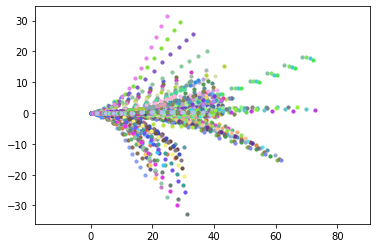

In [10]:
plot_path(target_labels[1500:1800])

In [120]:
# Build hystogram with passed distance

def get_passed_distance(trajectory):
    
    # From zero-zero to first future point
    total_distance = np.sqrt(trajectory[0][0]**2 + trajectory[0][1]**2)
    
    for i in range(len(trajectory) - 1):        
        current_point = trajectory[i]
        next_point = trajectory[i + 1]
        
        #print(current_point, next_point)
    
        dist = np.sqrt((next_point[0] - current_point[0])**2 + (next_point[1] - current_point[1])**2)
        total_distance += dist
        
    return total_distance

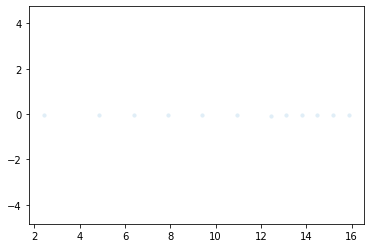

In [121]:
plot_path([target_labels[1]])

In [122]:
all_distances = []

for trajectory in target_labels:
    dist = get_passed_distance(trajectory)
    all_distances.append(dist)

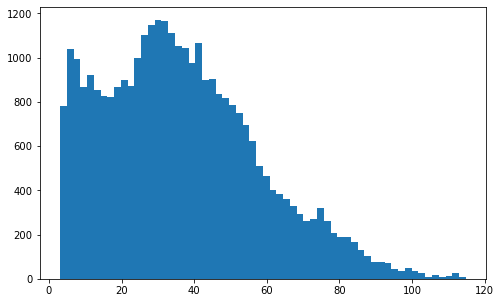

In [123]:
plt.figure(figsize=(8,5))
plt.hist(all_distances, 60, align='mid')
plt.show()

In [124]:
sum(dist < 5 for dist in all_distances)

846

Get angle between start and finish point

In [125]:
import math

def get_trajectory_heading(trajectory):
    
    last_point = trajectory[-1]
    radians = math.atan2(last_point[0], last_point[1]) 
    degrees = math.degrees(radians) 
        
    return degrees

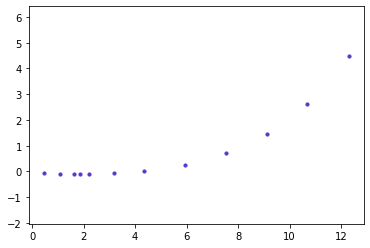

-19.990406918694948

In [126]:
indx = 50

plot_path([target_labels[indx]])
get_trajectory_heading(target_labels[indx])

In [127]:
all_heading = []

for trajectory in target_labels:
    heading = get_trajectory_heading(trajectory)
    all_heading.append(heading)

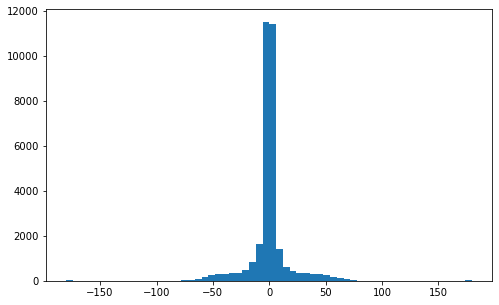

In [128]:
plt.figure(figsize=(8,5))
plt.hist(all_heading, 60, align='mid')
plt.show()

Get sample indexes at which heading change a lot

In [129]:
def condition(angle):
    return abs(angle) > 150

output = [idx for idx, element in enumerate(all_heading) if condition(element)]
output

[1051,
 1052,
 1053,
 1054,
 1055,
 1056,
 1057,
 1058,
 1059,
 1060,
 1061,
 1062,
 1063,
 1064,
 1065,
 1066,
 1279,
 1280,
 1281,
 1282,
 1331,
 1332,
 2028,
 2029,
 2030,
 2031,
 2032,
 2033,
 2034,
 2035,
 2036,
 2699,
 2700,
 4907,
 4908,
 4909,
 4910,
 4911,
 4912,
 4913,
 4914,
 4915,
 6572,
 6573,
 6574,
 6575,
 6973,
 6974,
 6975,
 6976,
 6977,
 6978,
 10674,
 11419,
 13753,
 13754,
 17570,
 17571,
 17572,
 17573,
 17574,
 17575,
 17576,
 17577,
 17578,
 18651,
 18652,
 18653,
 18654,
 18655,
 18656,
 18657,
 18658,
 18659,
 18660,
 18661,
 18662,
 18663,
 18664,
 18665,
 18666,
 18667,
 18668,
 18669,
 18670,
 18671,
 18672,
 18673,
 18674,
 18675,
 18676,
 18677,
 26871,
 26872,
 26873,
 26874,
 26875,
 26876,
 26877,
 26878,
 26879,
 26880,
 26881,
 26882,
 26883,
 26884,
 27113,
 29282,
 29283,
 29284,
 29285,
 30449]

In [130]:
def get_scene_representation_sequence(target_instance_token, start_prediction_sample_token, prediction_length):

    current_sample_token = start_prediction_sample_token

    for i in range(prediction_length * 2):
        current_sample = nusc.get('sample', current_sample_token)
        
        annotation = helper.get_sample_annotation(instance_token, current_sample_token)        
        nusc.render_annotation(annotation['token'])
        
        current_sample_token = current_sample['next']

In [131]:
from nuscenes.eval.prediction.splits import get_prediction_challenge_split

valid_samples = get_prediction_challenge_split("train_val", dataroot=DATAROOT)

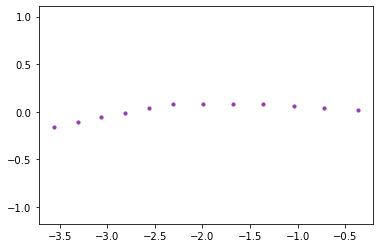

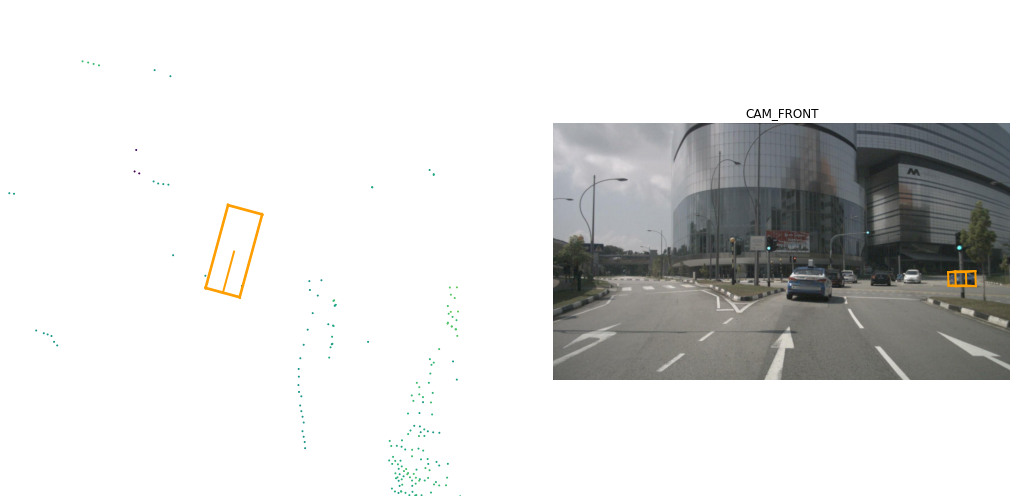

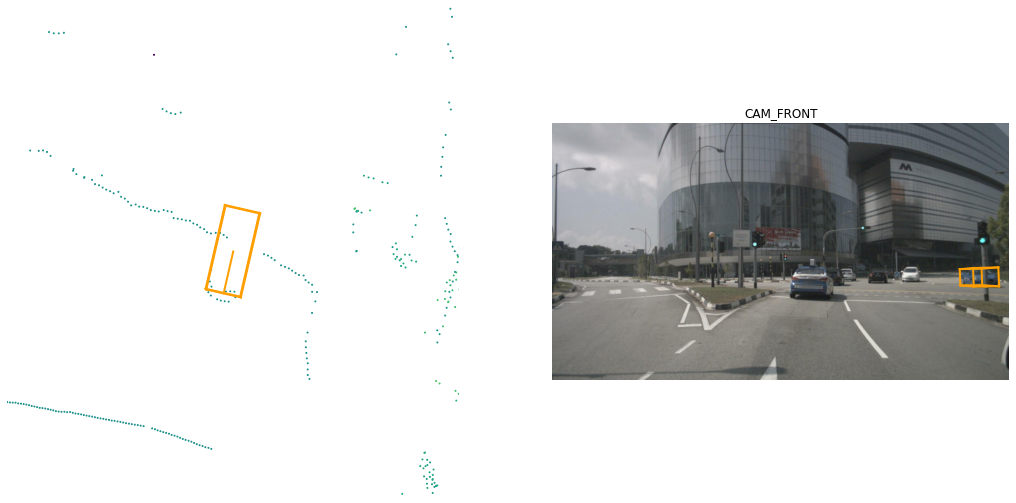

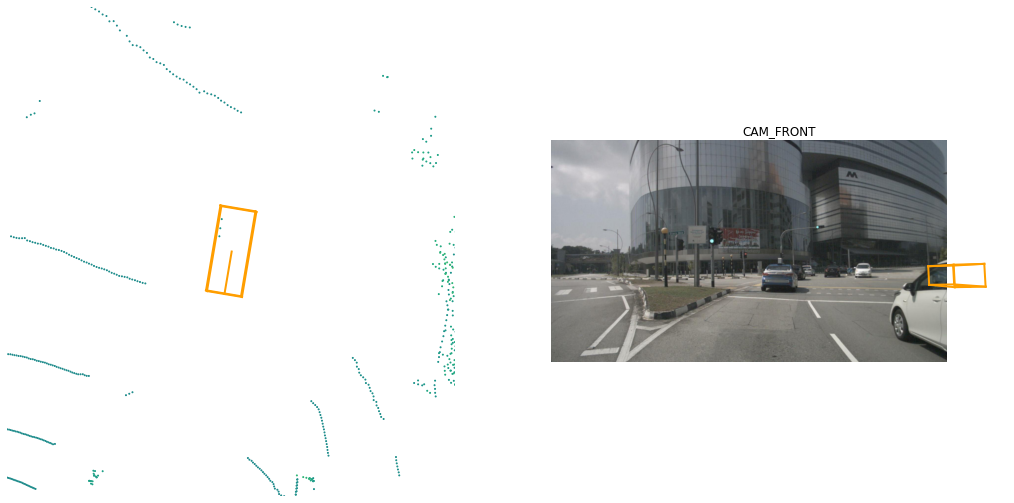

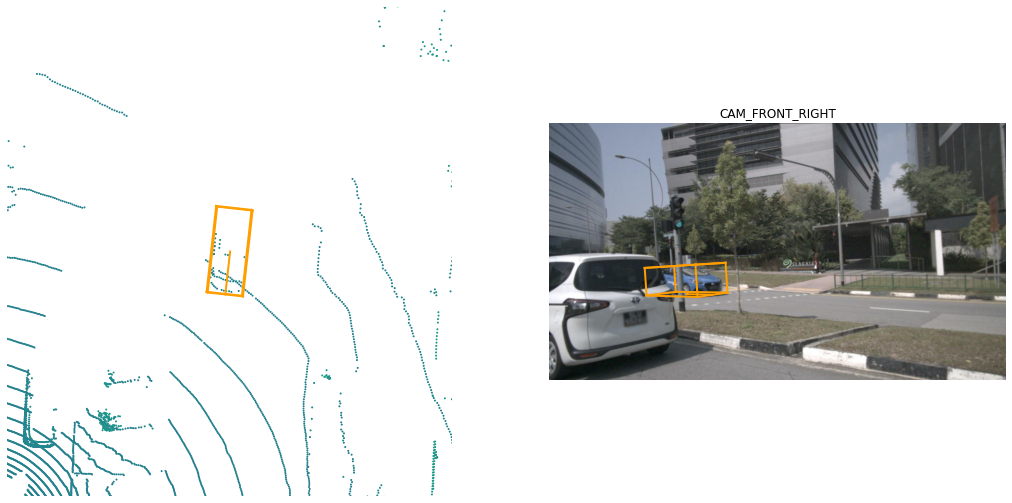

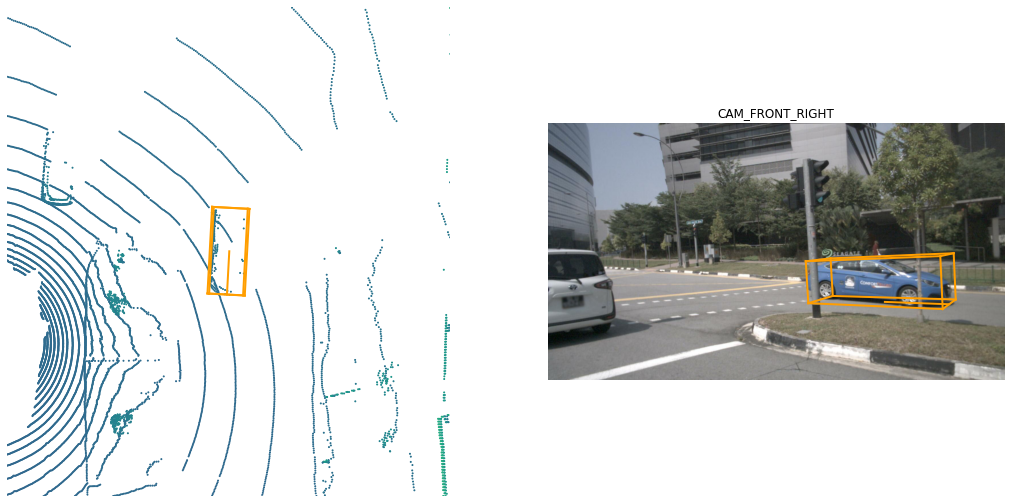

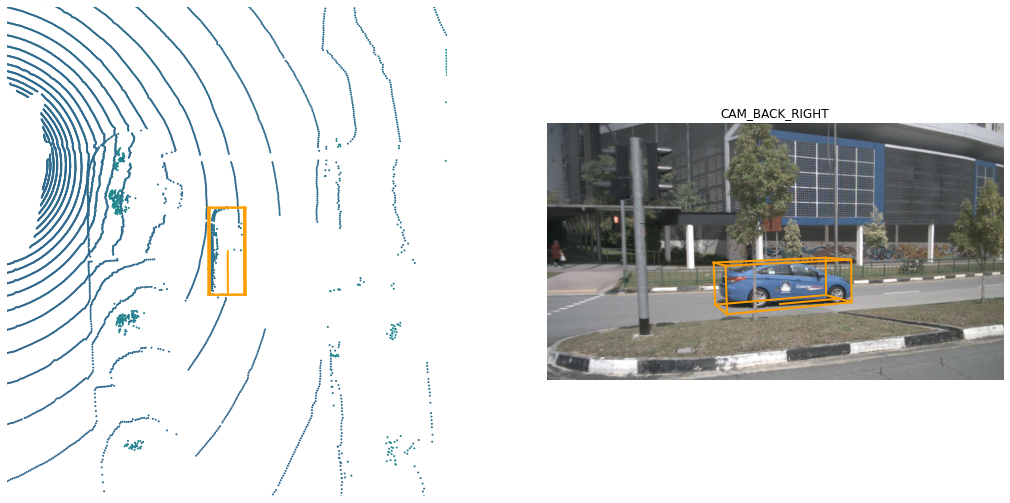

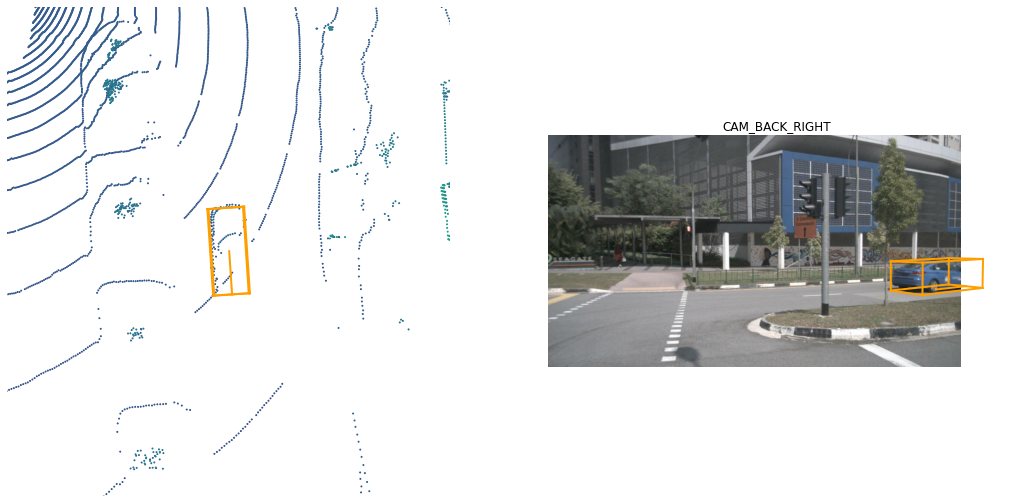

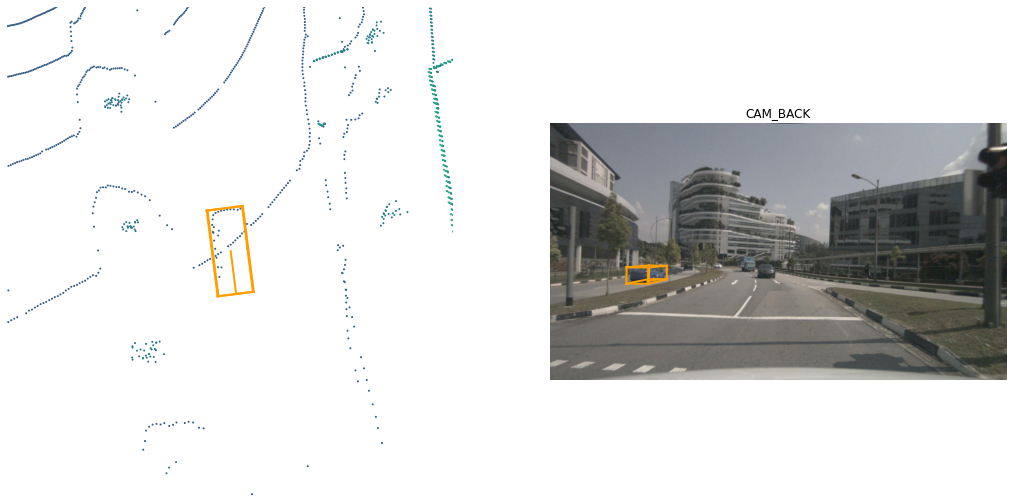

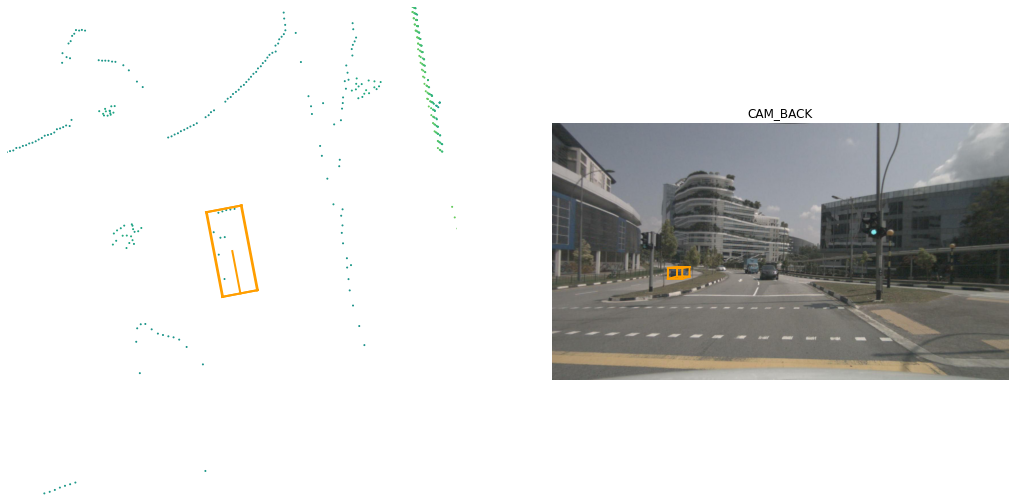

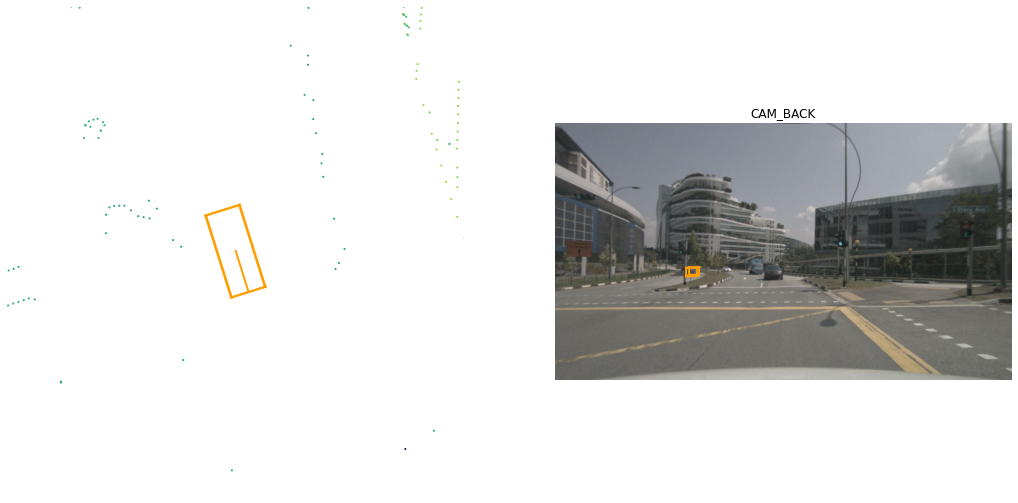

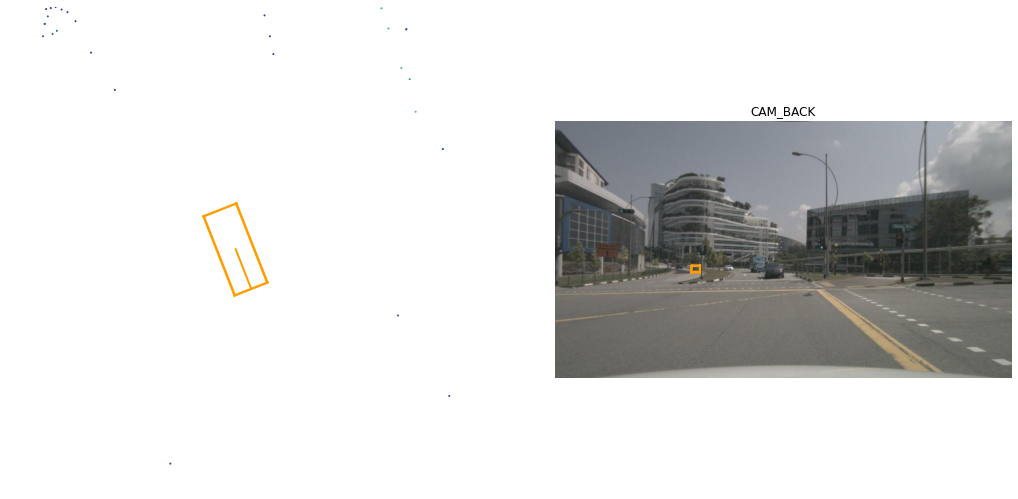

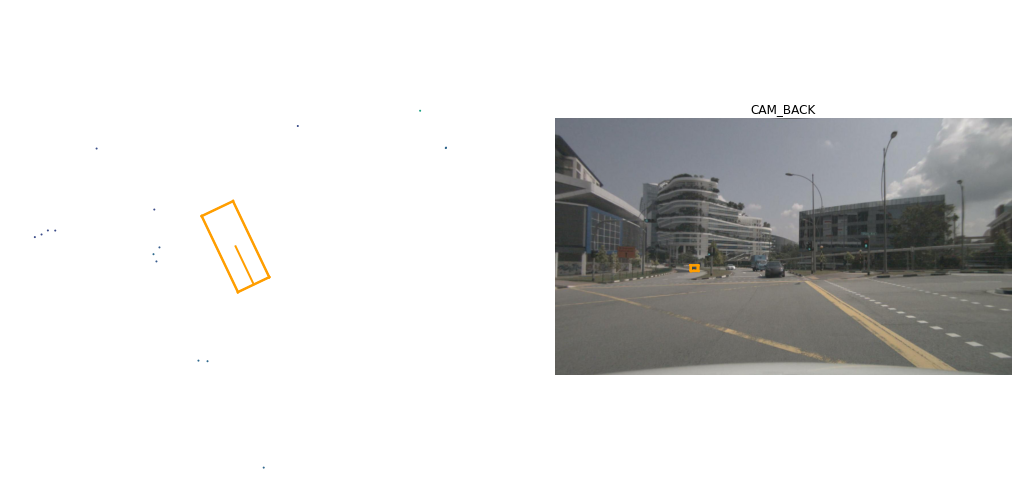

In [137]:
index = 10

plot_path([target_labels[output[index]]])

instance_token, sample_token = valid_samples[output[index]].split('_')
get_scene_representation_sequence(instance_token, sample_token, 6)

### Analysis of trajectory sets

In [27]:
import pickle

# Epsilon is the amount of coverage in the set, 
# i.e. a real world trajectory is at most 8 meters from a trajectory in this set
# We released the set for epsilon = 2, 4, 8. Consult the paper for more information
# on how this set was created

PATH_TO_EPSILON_SET = "./covernet_trajectory_set/epsilon_2.pkl"
trajectories = pickle.load(open(PATH_TO_EPSILON_SET, 'rb'))

#Saved them as a list of lists
trajectories_set = torch.Tensor(trajectories)

In [28]:
len(trajectories_set)

2206

In [33]:
delta_x = 100
delta_y = 100

filtered_set = [traj for traj in trajectories_set if traj[-1][1] > 0 and abs(traj[-1][0]) < delta_x and abs(traj[-1][1]) < delta_y]
len(filtered_set)

2172

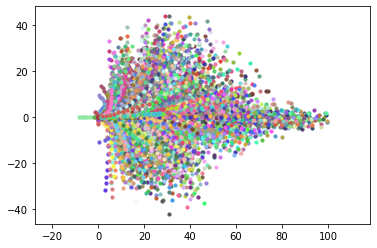

In [34]:
plot_path(filtered_set)